In [8]:
import os
import re
import time
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

torch.manual_seed(1)

In [43]:
#just load the data
import preprocess
import utils.load_acc

stiffness_o, mass_o = preprocess.task()

acc = utils.load_acc.task()


(101, 153)


In [44]:
#extra process
from sklearn.preprocessing import StandardScaler

print("origin:")
print(stiffness_o)
print(mass_o)

ss_s, ss_m = StandardScaler(), StandardScaler()
ss_s.fit(stiffness_o);ss_m.fit(mass_o)

stiffness, mass = ss_s.transform(stiffness_o), ss_m.transform(mass_o)

print("after: ")
print(stiffness, mass)



origin:
(array([1.08796486e+69, 1.08808383e+69, 1.08908017e+69, 1.08885479e+69,
       1.08931804e+69, 1.08768576e+69, 1.08868542e+69, 1.08900052e+69,
       1.08920405e+69, 1.08833844e+69, 1.08931116e+69, 1.08477810e+69,
       1.08899540e+69, 1.08901423e+69, 1.08931106e+69, 1.08882217e+69,
       1.08874177e+69, 1.08911277e+69, 1.08856633e+69, 1.08930794e+69,
       1.08911155e+69, 1.08675478e+69, 1.08931483e+69, 1.08868772e+69,
       1.08920844e+69, 1.08918387e+69, 1.08928732e+69, 1.08931747e+69,
       1.08714420e+69, 1.08644231e+69, 1.08928509e+69, 1.08633191e+69,
       1.08819950e+69, 1.08655127e+69, 1.08804704e+69, 1.08569494e+69,
       1.08744433e+69, 1.08603763e+69, 1.08834232e+69, 1.08921891e+69,
       1.08758280e+69, 1.08907671e+69, 1.08851018e+69, 1.08926884e+69,
       1.08931794e+69, 1.08838769e+69, 1.08853736e+69, 1.08932341e+69,
       1.08363488e+69, 1.08899908e+69, 1.08884836e+69, 1.08910354e+69,
       1.08924674e+69, 1.08925671e+69, 1.08629646e+69, 1.08895196e+6

In [77]:
# trans to torch tensor
print(type(stiffness[0]))
print(len(mass[0]))

s = np.array([stiffness[0]])

print(s.shape)
for i in range(1, 3):
    s= np.concatenate((s, np.array([stiffness[i]])), axis=0)

for i in range(3):
    s = np.concatenate((s, np.array([mass[i]])), axis=0)

print(s.shape)

print(acc.shape)

src = torch.tensor(s, dtype=torch.float64)

tgt = torch.tensor(acc, dtype=torch.float64)

src = torch.unsqueeze(src, dim=1)

tgt = torch.unsqueeze(tgt, dim=1)

print(src.shape, tgt.shape)

#dataloader

print(src.shape)
print(tgt.shape)

for i in range(4):
    src = torch.cat((src, src), 1)

for i in range(4):
    tgt = torch.cat((tgt, tgt), 1)

print(src.shape)
print(tgt.shape)

print(tgt)




<class 'numpy.ndarray'>
153
(1, 153)
(6, 153)
(101, 153)
torch.Size([6, 1, 153]) torch.Size([101, 1, 153])
torch.Size([6, 1, 153])
torch.Size([101, 1, 153])
torch.Size([6, 16, 153])
torch.Size([101, 16, 153])
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  8.1540e+00,  3.5931e+01,  ..., -6.8008e-02,
          -6.7872e-02, -6.7872e-02],
         [ 0.0000e+00,  8.1540e+00,  3.5

torch.Size([6, 16, 153]) torch.Size([101, 16, 153])
epoch:  9  time:  2.5 loss:  9842.3720703125
epoch:  19  time:  5.6 loss:  7622.703125
epoch:  29  time:  9.3 loss:  7037.05810546875
epoch:  39  time:  12.2 loss:  6446.90869140625
epoch:  49  time:  14.7 loss:  5970.775390625
epoch:  59  time:  17.6 loss:  5911.50244140625
epoch:  69  time:  19.8 loss:  5697.2568359375
epoch:  79  time:  21.8 loss:  5741.08203125
epoch:  89  time:  23.9 loss:  5826.3623046875
epoch:  99  time:  25.9 loss:  5760.34326171875


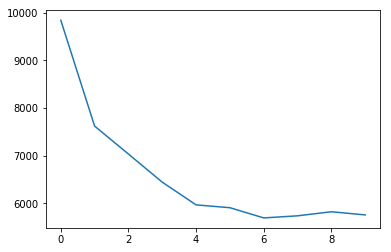

In [86]:
#test model
def pretty_time(time, degree=1):
    return str(int(time // 60)) + "m" + str(round(time % 60, degree)) if time > 60 else round(time, degree)

from net.model import FesNet

net = FesNet(element_dim=153)

criterion =  nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=10)

start_time = time.time()

loss_list = []

print(src.shape, tgt.shape)

src, tgt = src.float(), tgt.float()

for i in range(100):
    total_loss = 0.

    probs = net(src, tgt)

    net.zero_grad()
  
    loss = criterion(probs.reshape(-1), tgt.reshape(-1))

    loss.backward()
    torch.nn.utils.clip_grad_norm_(net.parameters(), 10)
    optimizer.step()

    total_loss += loss.item() / 16
    if (i+1) % 10 == 0:
        time_past = time.time() - start_time
        cur_loss = total_loss
        loss_list.append(cur_loss)
        total_loss = 0
        print("epoch: ", i, " time: ", pretty_time(time_past), "loss: ", cur_loss)
    if (i+1) % 20 == 0:
        pass
        #print(probs)
        #print(tgt)

plt.plot(loss_list)

plt.show()


In [87]:
probs = net(src, tgt)

print(probs.shape)

torch.Size([101, 16, 153])


In [94]:
#gap = (probs - tgt).view(16, 101, 153)
p = probs.view(16, 101, 153)[0]
t = tgt.view(16, 101, 153)[0]

print(p)
print(t)
print(gap[0])

tensor([[-2.5106e-01,  2.4675e-01,  8.1074e+02,  ..., -7.2022e-01,
         -3.8726e+00, -2.4511e+00],
        [-2.8042e-01,  2.6278e-01,  7.8804e+02,  ..., -8.9604e-01,
         -3.8628e+00, -2.4479e+00],
        [-2.8673e-01,  2.8666e-01,  7.2723e+02,  ..., -7.9629e-01,
         -3.8600e+00, -2.4451e+00],
        ...,
        [-4.6520e-01, -1.4034e-01, -8.6166e+02,  ..., -2.7501e+00,
         -4.1395e+00, -2.4826e+00],
        [ 6.2399e-01, -1.0946e-01, -8.6810e+02,  ..., -2.4423e+00,
         -3.7870e+00, -2.4838e+00],
        [ 5.5481e-01, -7.7003e-02, -8.2259e+02,  ..., -2.3747e+00,
         -4.1066e+00, -2.4833e+00]], grad_fn=<SelectBackward>)
tensor([[   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
            0.0000],
        [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
            0.0000],
        [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
            0.0000],
        ...,
        [   0.0000,    5.3402, -188.1310,  ...,   -1.237